In [3575]:
# Importing the libraries and removing the warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [3576]:
df = pd.read_csv('day.csv')
df.shape

(730, 16)

In [3577]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3578]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
# creating the font dictionaries to set the style for the x and y labels for our plots
fontdict = {'fontsize': 15, 'fontweight' : 5, 'color' : 'Brown'}

Let's analyse the relationship between numerical variables and the dependent variable by plotting pairplot

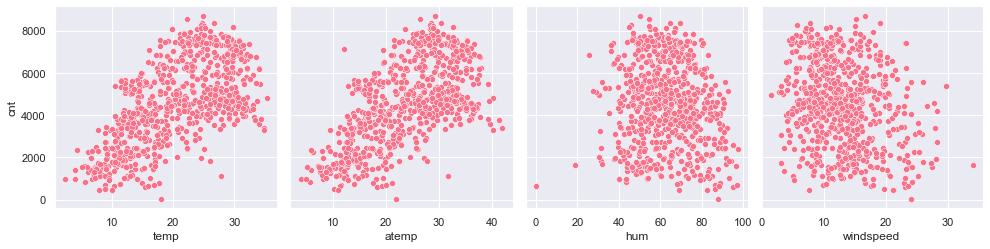

In [3579]:
sns.pairplot(data=df,x_vars=['temp','atemp','hum','windspeed'],y_vars='cnt', height = 3.5)
plt.show()

Clearly, total bikes rented count looks highly correlated with actual and felt temperature, but not so much with humidity and windspeed

Let's analyse the distribution of these numerical variables individually just to get the idea of their spread

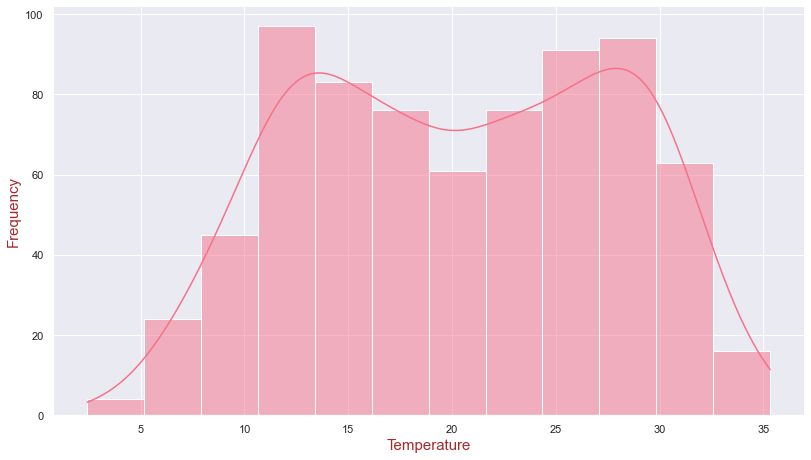

In [3580]:
sns.displot(data=df,x="temp",kde=True,height=6.5,aspect=1.75)
plt.xlabel('Temperature',fontdict=fontdict)
plt.ylabel('Frequency',fontdict=fontdict)
plt.show()

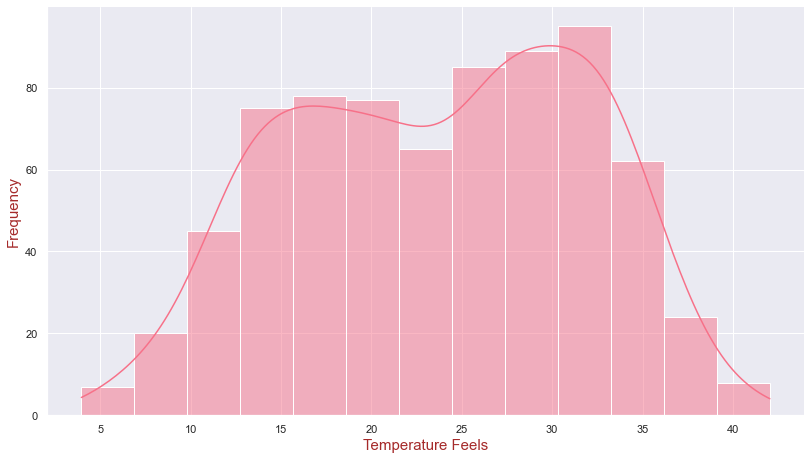

In [3581]:
sns.displot(data=df,x="atemp",kde=True,height=6.5,aspect=1.75)
plt.xlabel('Temperature Feels',fontdict=fontdict)
plt.ylabel('Frequency',fontdict=fontdict)
plt.show()

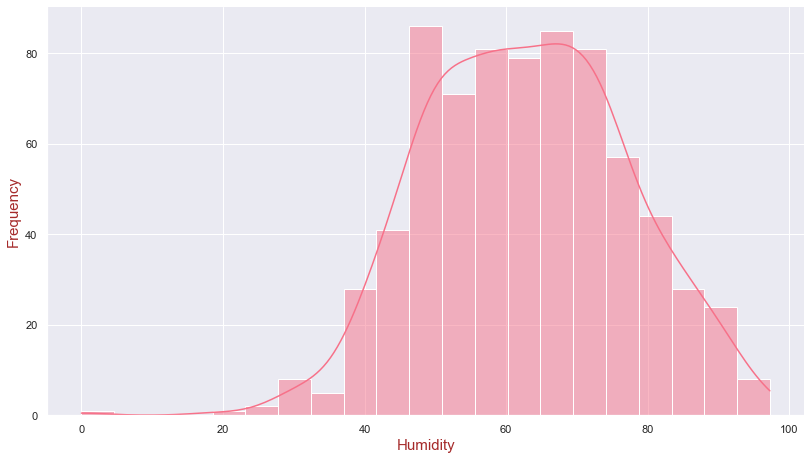

In [3582]:
sns.displot(data=df,x="hum",kde=True,height=6.5,aspect=1.75)
plt.xlabel('Humidity',fontdict=fontdict)
plt.ylabel('Frequency',fontdict=fontdict)
plt.show()

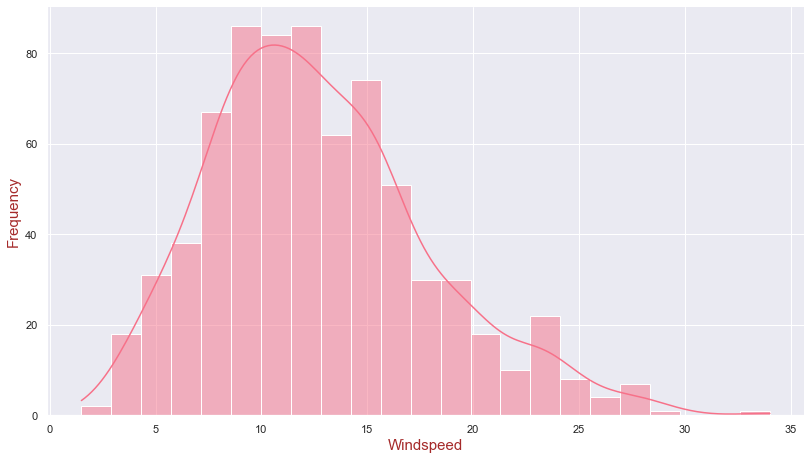

In [3583]:
sns.displot(data=df,x="windspeed",kde=True,height=6.5,aspect=1.75)
plt.xlabel('Windspeed',fontdict=fontdict)
plt.ylabel('Frequency',fontdict=fontdict)
plt.show()

Since bikes are rented by casual or registered users, let's just analyse the ratio of registered users to total. This may or may not be useful going forward, but no harm in analying that

In [3584]:
def calRegUserRatio(x):
    return x["registered"]/(x["casual"] + x["registered"])

# regUsersRatio is short for registeredUsersRatioOfTotalUsers
df["regUsersRatio"] = df.apply(calRegUserRatio, axis=1)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,regUsersRatio
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,0.663959
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,0.836454
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0.911045
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0.930858
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0.948750


In [3585]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   instant        730 non-null    int64  
 1   dteday         730 non-null    object 
 2   season         730 non-null    int64  
 3   yr             730 non-null    int64  
 4   mnth           730 non-null    int64  
 5   holiday        730 non-null    int64  
 6   weekday        730 non-null    int64  
 7   workingday     730 non-null    int64  
 8   weathersit     730 non-null    int64  
 9   temp           730 non-null    float64
 10  atemp          730 non-null    float64
 11  hum            730 non-null    float64
 12  windspeed      730 non-null    float64
 13  casual         730 non-null    int64  
 14  registered     730 non-null    int64  
 15  cnt            730 non-null    int64  
 16  regUsersRatio  730 non-null    float64
dtypes: float64(5), int64(11), object(1)
memory usage: 97.1

So we don't have null values present here, so no need to handle those

'dteday' when broken down into day, month, time components using datetime or DatetimeIndex functions gave weird values, probably it was not perfectly set up as datetime. So we will break it manually. It is in the form of day-month-year. Please note that I have removed the steps where I break down the dteday using DatetimeIndex to keep the notebook error free

In [3586]:
df["day"] = df["dteday"].apply(lambda x: int(str(x).split('-')[0]))
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,regUsersRatio,day
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,0.663959,1
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,0.836454,2
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0.911045,3
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0.930858,4
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0.948750,5


In [3587]:
df.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

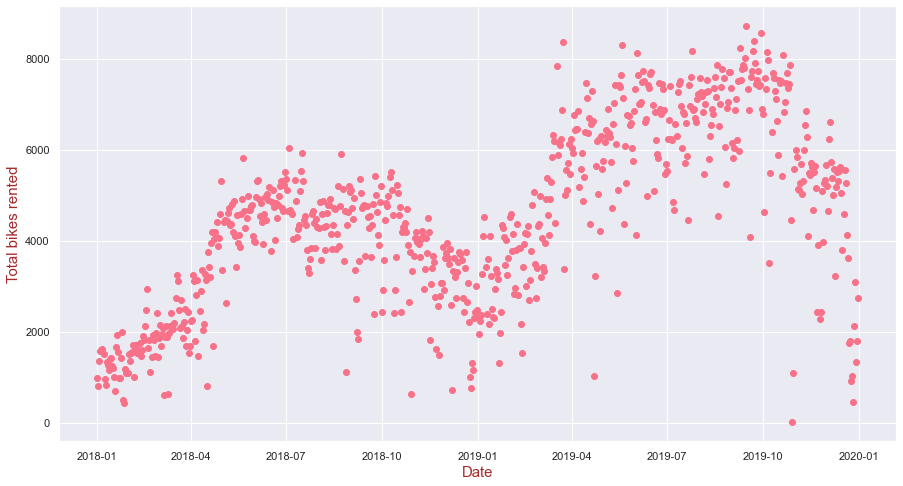

In [3588]:
from datetime import date

# Creating the right date column with values in correct format
# since 'dteday' column was error prone
def addDate(df):
    yr = 2018
    if df["yr"] == 1:
        yr = 2019
    return date(yr, int(df["mnth"]), int(df["day"]))

df["date"] = df.apply(addDate, axis=1)
plt.scatter(df["date"],df["cnt"])
plt.xlabel('Date', fontdict=fontdict)
plt.ylabel('Total bikes rented', fontdict=fontdict) 
plt.show()

Now, we will draw the pattern of bikes rented by casual vs registered users with respect to time

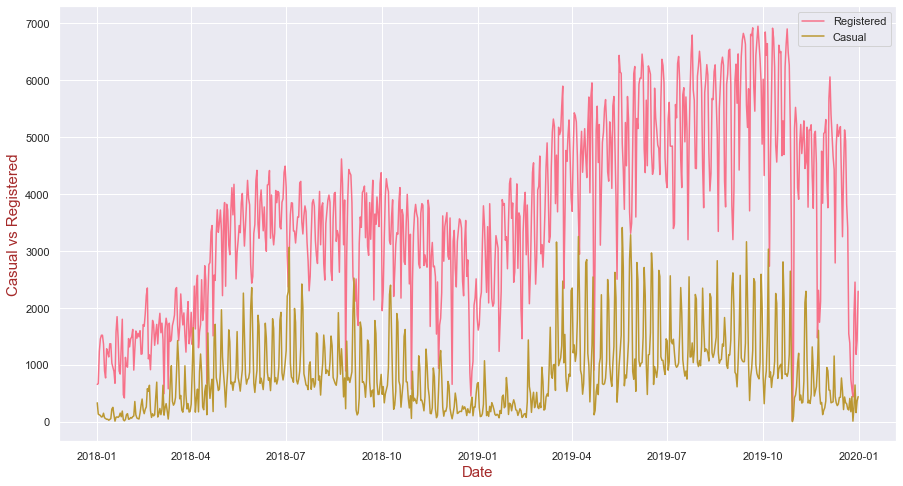

In [3589]:
sns.lineplot(data=df,y = "registered", x="date")
sns.lineplot(data=df,y = "casual", x="date")
plt.xlabel('Date', fontdict=fontdict)
plt.ylabel('Casual vs Registered', fontdict=fontdict) 
plt.legend(['Registered','Casual'])
plt.show()

As we noticed above, registered users rented way more bikes consistenly than the casual users, but their pattern across time seems pretty similar

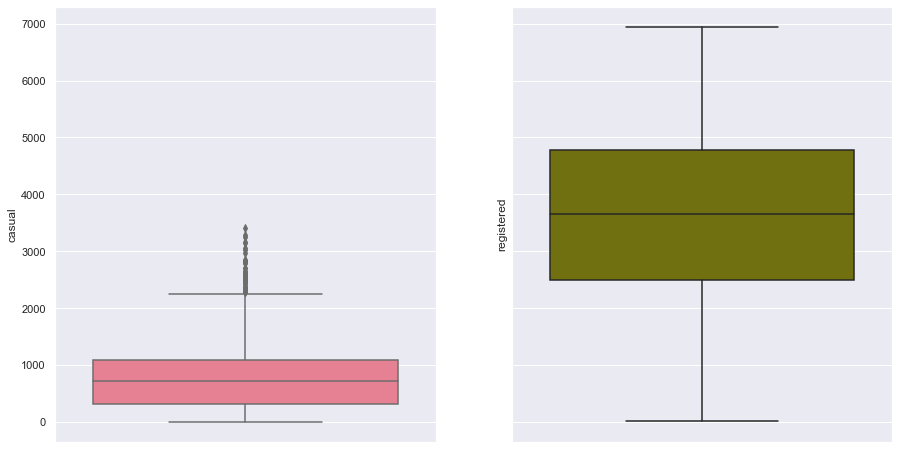

In [3590]:
f, ax = plt.subplots(ncols = 2, sharey= True)
sns.boxplot(data=df, y = "casual", ax=ax[0])
sns.boxplot(data= df, y = "registered",ax=ax[1],color='olive')
plt.show()

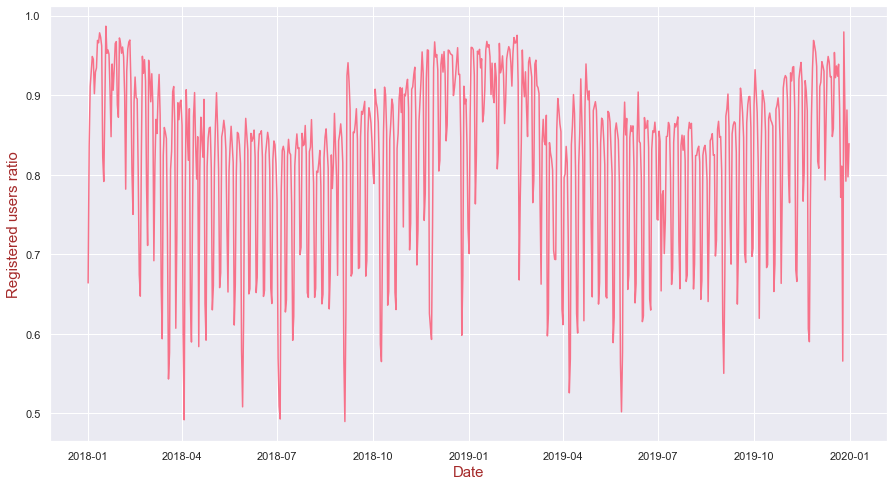

In [3591]:
sns.lineplot(data=df,y = "regUsersRatio", x="date")
plt.xlabel('Date', fontdict=fontdict)
plt.ylabel('Registered users ratio', fontdict=fontdict) 
plt.show()

Interesting pattern here. The ratio of registered users vs total users starts good, goes down during middle of the year and then picks up again during the year end. And the pattern repeated for the year 2019 as well. May be or may not be useful information but good to know. 

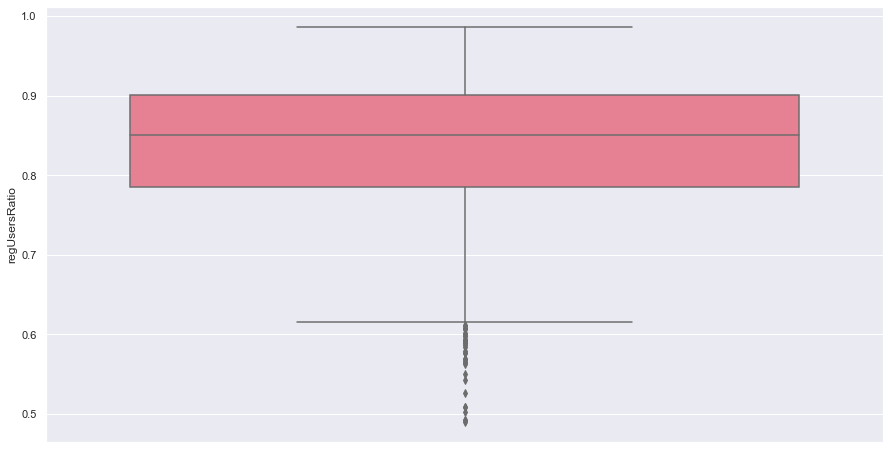

In [3592]:
sns.boxplot(data=df, y = "regUsersRatio")
plt.show()

In [3593]:
df.drop(["regUsersRatio"],axis=1,inplace=True)

#####  Let's conver the values in the categorical column to string values since the numeric values in them falsely implies that there is some order in the values, when there is no such order

In [3594]:
def getSeasons(x):
    if x ==1:
        return "spring"
    elif x==2:
        return "summer"
    elif x==3:
        return "fall"
    else:
        return "winter"
    
df["season"] = df["season"].apply(getSeasons)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,date
0,1,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,2018-01-01
1,2,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,2,2018-01-02
2,3,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,3,2018-01-03
3,4,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,4,2018-01-04
4,5,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,5,2018-01-05


In [3595]:
df["season"].unique()

array(['spring', 'summer', 'fall', 'winter'], dtype=object)

In [3596]:
df["weathersit"].unique()

array([2, 1, 3], dtype=int64)

In [3597]:
df["weekday"].unique()

array([6, 0, 1, 2, 3, 4, 5], dtype=int64)

In [3598]:
def getDayOfTheWeek(x):
    if x==0:
        return "Sunday"
    elif x==1:
        return "Monday"
    elif x==2:
        return "Tuesday"
    elif x==3:
        return "Wednesday"
    elif x==4:
        return "Thursday"
    elif x==5:
        return "Friday"
    else:
        return "Saturday"
    
df["weekday"] = df["weekday"].apply(getDayOfTheWeek)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,date
0,1,01-01-2018,spring,0,1,0,Saturday,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,2018-01-01
1,2,02-01-2018,spring,0,1,0,Sunday,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,2,2018-01-02
2,3,03-01-2018,spring,0,1,0,Monday,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,3,2018-01-03
3,4,04-01-2018,spring,0,1,0,Tuesday,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,4,2018-01-04
4,5,05-01-2018,spring,0,1,0,Wednesday,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,5,2018-01-05


In [3599]:
df["weekday"].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [3600]:
def getWeatherSituation(x):
    if x==1:
        return "Clear"
    elif x==2:
        return "Cloudy"
    elif x==3:
        return "Light Rain"
    else:
        return "Heavy Rain"
    
df["weathersit"] = df["weathersit"].apply(getWeatherSituation)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,date
0,1,01-01-2018,spring,0,1,0,Saturday,0,Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,1,2018-01-01
1,2,02-01-2018,spring,0,1,0,Sunday,0,Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,2,2018-01-02
2,3,03-01-2018,spring,0,1,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,3,2018-01-03
3,4,04-01-2018,spring,0,1,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,4,2018-01-04
4,5,05-01-2018,spring,0,1,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,5,2018-01-05


let's do some segmented univariate analysis and check the pattern of categorical variables with respect to the shared bikes count, the dependent variable

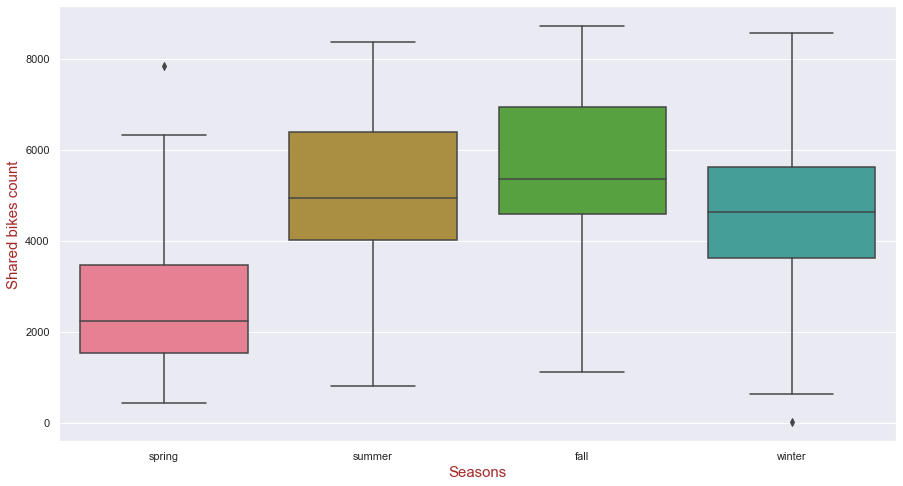

In [3601]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "season", y = "cnt")
plt.xlabel('Seasons',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

'fall' is the clear winner here, while 'spring' generally has the lowest shared bikes count

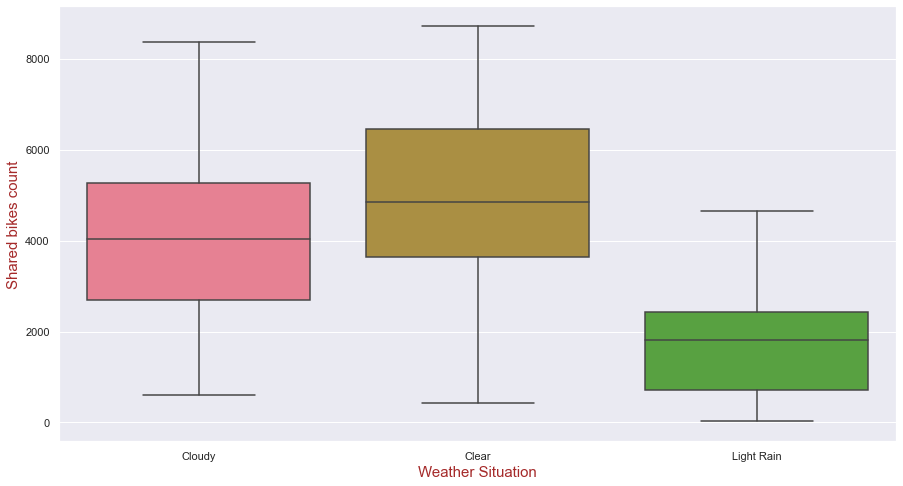

In [3602]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "weathersit", y = "cnt")
plt.xlabel('Weather Situation',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

The pattern across the weather situation is prettu intuitibve in itself. Users would like to ride a bike in clear weather and they would like to avoid it during rainfall, and the data shows the same insight.

In [3603]:
df["mnth"].value_counts()

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64

In [3604]:
def getMonthName(x):
    if x==1:
        return "January"
    elif x==2:
        return "February"
    elif x==3:
        return "March"
    elif x==4:
        return "April"
    elif x==5:
        return "May"
    elif x==6:
        return "June"
    elif x==7:
        return "July"
    elif x==8:
        return "August"
    elif x==9:
        return "September"
    elif x==10:
        return "October"
    elif x==11:
        return "November"
    else:
        return "December"

df["mnth"] = df["mnth"].apply(getMonthName)

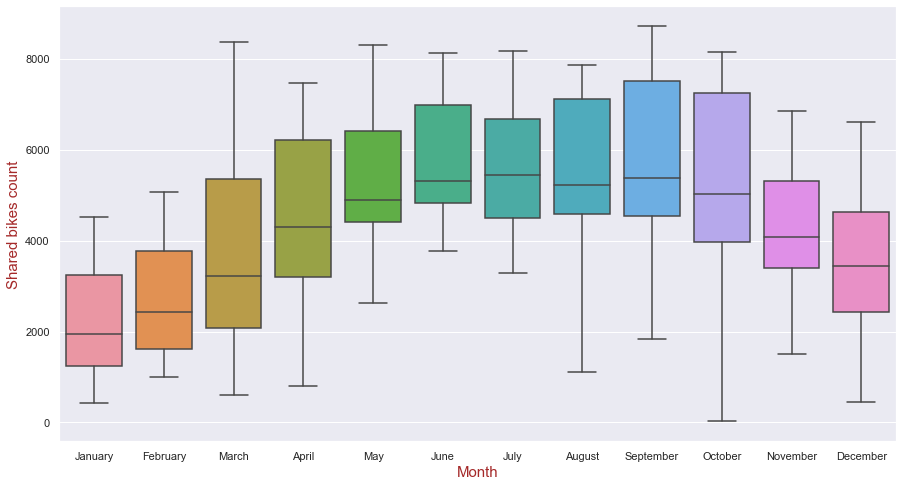

In [3605]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.boxplot(data=df , x = "mnth", y = "cnt")
plt.xlabel('Month',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

As seen above, the bikes are rented more during the mid months of the year as compared to year start and year end.

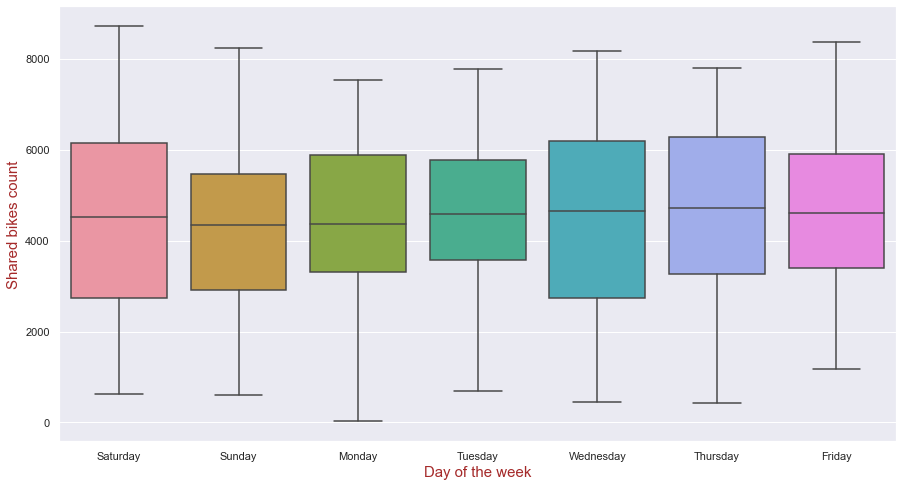

In [3606]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "weekday", y = "cnt")
plt.xlabel('Day of the week',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

So, not much of a pattern to notice for shared bikes count with respect to days of the week

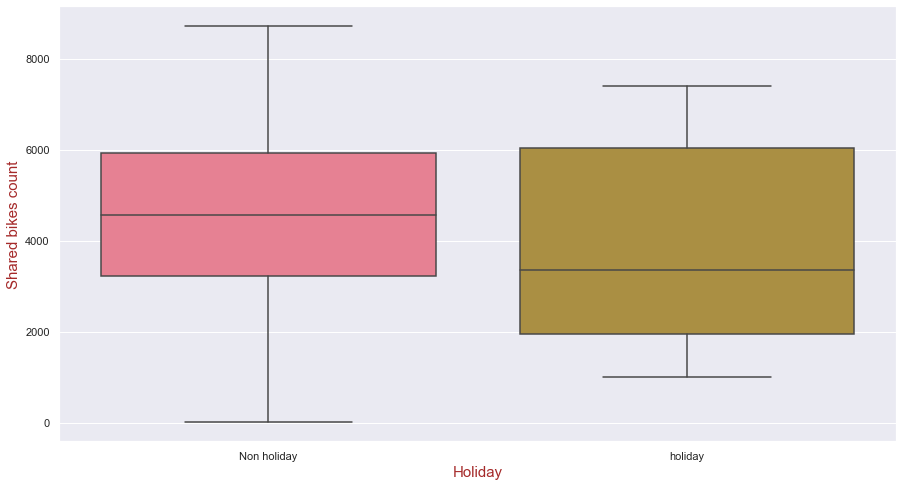

In [3607]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "holiday", y = "cnt")
plt.xlabel('Holiday',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
locs, texts = plt.xticks()
plt.xticks(locs, list(map(lambda x: 'Non holiday' if x ==0 else 'holiday', locs)))
plt.show()

Users generally like to rent the bikes during non holiday days. There could be multiple reasons, users generally rent the bike while going to work, or they generally want to spend time with family or go out of the station during holidays, hence the drop during holidays

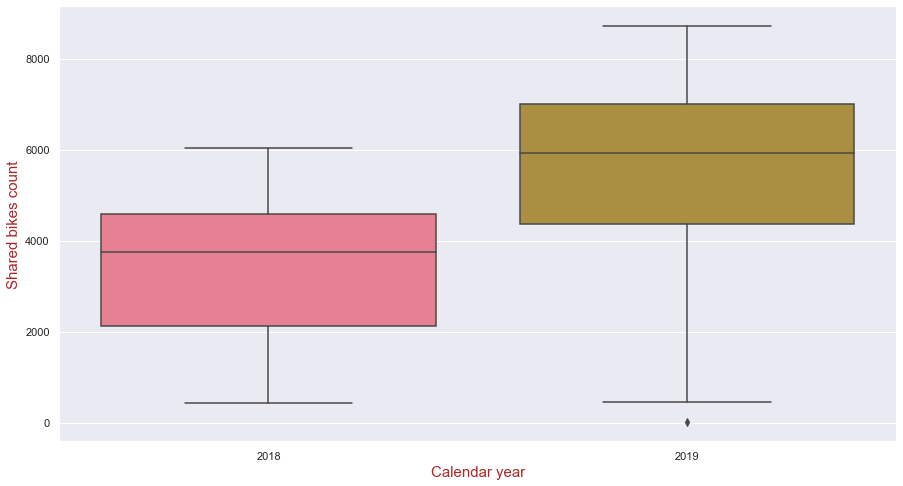

In [3608]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "yr", y = "cnt")
plt.xlabel('Calendar year',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
locs, texts = plt.xticks()
plt.xticks(locs, list(map(lambda x: '2018' if x ==0 else '2019', locs)))
plt.show()

This is very clear pattern, the shared bikes count boomed in year 2019 as compared to 2018. May be the word of mouth, or better advertising, or just increases awareness of the company played a role in that boom.

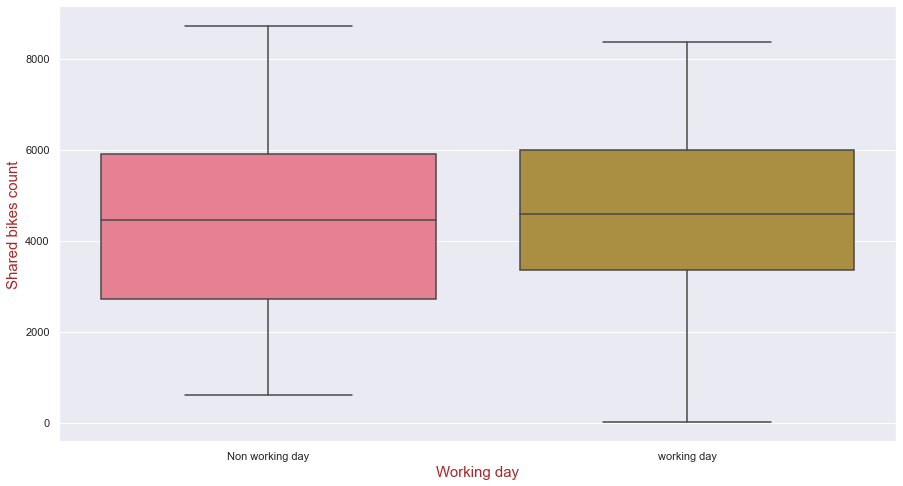

In [3609]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "workingday", y = "cnt")
plt.xlabel('Working day',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
locs, texts = plt.xticks()
plt.xticks(locs, list(map(lambda x: 'Non working day' if x ==0 else 'working day', locs)))
plt.show()

Not much of a difference here, but non working day's 25th percentile is lower than that of working day. Probably the thought we put down for holiday vs non holiday - that people tend to rent the bike while going to work - is substantiated by above plot.

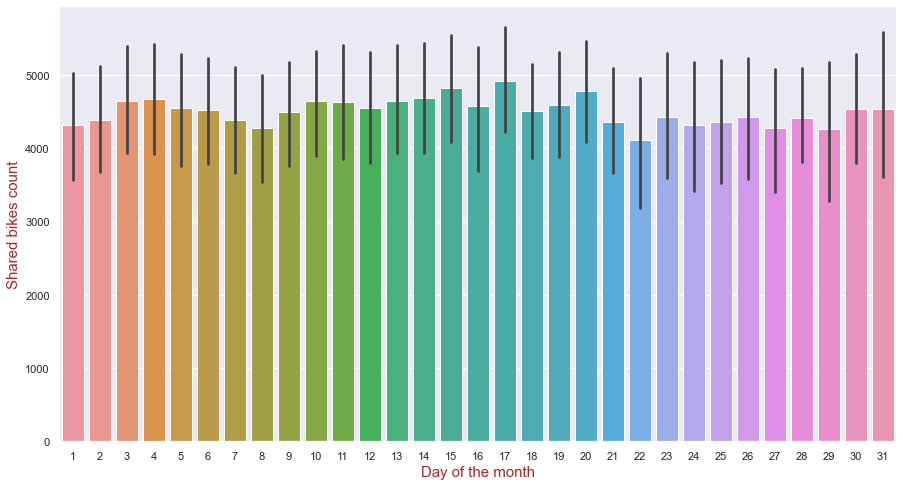

In [3610]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.barplot(data=df , x = "day", y = "cnt")
plt.xlabel('Day of the month',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

Not much of a pattern to notice for rented bikes count with respect to day of the month

#### Now let's start the main process of preparing data for model buildiing

First we will create dummies columns for categorical variables. We will delete one of the column out of the column created for each level of a categorical variable, since all values of a categorical column with m levels can be represented by m-1 columns.

In [3611]:
categVars = ["season","weekday","weathersit","mnth"]

In [3612]:
for cv in categVars:
    dummydf = pd.get_dummies(df[cv],drop_first=True) # drop_first = True will remove the redundant column
    df= pd.concat([df, dummydf],axis=1)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,December,February,January,July,June,March,May,November,October,September
0,1,01-01-2018,spring,0,January,0,Saturday,0,Cloudy,14.110847,...,0,0,1,0,0,0,0,0,0,0
1,2,02-01-2018,spring,0,January,0,Sunday,0,Cloudy,14.902598,...,0,0,1,0,0,0,0,0,0,0
2,3,03-01-2018,spring,0,January,0,Monday,1,Clear,8.050924,...,0,0,1,0,0,0,0,0,0,0
3,4,04-01-2018,spring,0,January,0,Tuesday,1,Clear,8.200000,...,0,0,1,0,0,0,0,0,0,0
4,5,05-01-2018,spring,0,January,0,Wednesday,1,Clear,9.305237,...,0,0,1,0,0,0,0,0,0,0


Now, we will drop the original categorical variables, since they won't be needed anymore

In [3613]:
df.drop(categVars,axis=1,inplace=True)

In [3614]:
df.shape

(730, 36)

Next, we will remove the unneeded columns. 

'instant' just shows the row number, won't be useful for creating models.

'casual' and 'registered' are just the break up of 'cnt' variable - if we build a model to predict 'cnt' - we are basically predicting 'casual' + 'registered'.

'dteday' is not needed since we have derived metrics from that - date and year (month was already given)

'date' was nothing but a proxy of dteday that we created to plot some graphs.

So we will remove these columns.

In [3615]:
df.drop(["instant","dteday","casual","registered","date"],axis=1,inplace=True)
df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'day', 'spring', 'summer', 'winter', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Cloudy', 'Light Rain',
       'August', 'December', 'February', 'January', 'July', 'June', 'March',
       'May', 'November', 'October', 'September'],
      dtype='object')

Splitting the data into `train` and `test`. We will keep 70% of the total data as the train data.

In [3616]:
df_train, df_test = train_test_split(df, train_size= 0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 31)
(220, 31)


In [3617]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,day,spring,...,December,February,January,July,June,March,May,November,October,September
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,2,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,3,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,4,1,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,5,1,...,0,0,1,0,0,0,0,0,0,0


In [3618]:
numVars = ["temp","atemp","hum","windspeed"]

Next step in model building is the scaling of numerical variables. We will use `Normalization` to scale the numerical variables, so that the values remain between 0 and 1.

In [3619]:
scaler = MinMaxScaler()

In [3620]:
df_train[numVars] = scaler.fit_transform(df_train[numVars])
df_train[numVars].head()

,temp,atemp,hum,windspeed
576,0.815169,0.766351,0.725633,0.264686
426,0.442393,0.438975,0.640189,0.255342
728,0.245101,0.200348,0.498067,0.663106
482,0.395666,0.391735,0.504508,0.188475
111,0.345824,0.318819,0.751824,0.380981


In [3621]:
df_train[numVars].describe()

,temp,atemp,hum,windspeed
count,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.513156,0.650480,0.320883
std,0.225858,0.212410,0.145846,0.169803
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179
50%,0.542596,0.529718,0.653714,0.296763
75%,0.735215,0.688457,0.754830,0.414447
max,1.000000,1.000000,1.000000,1.000000


Now we will plot the heatmap to check the correlation numbers among numerical variables along with dependent variable

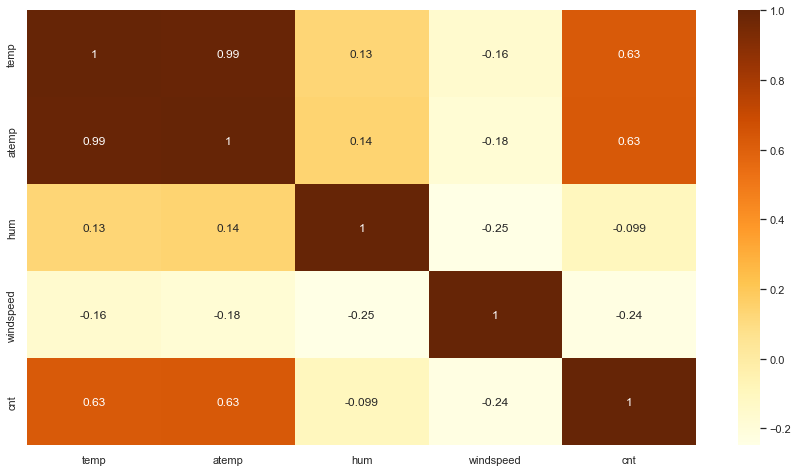

In [3622]:
sns.set(rc = {'figure.figsize' : (15,8)})
correlationCheckVars = numVars + ['cnt']
sns.heatmap(df[correlationCheckVars].corr(),cmap="YlOrBr", annot=True)
plt.show()

temperature and real feel temperature are highly correlated. We can drop any of them right now, but we are going to keep them for time being, since while selecting features via REF or while checking VIF we are going to drop one of them anyways

Next we will break the training data to separate dependent and predictor variables

In [3623]:
y_train = df_train.pop('cnt')
X_train = df_train.copy(deep=True)

In [3624]:
# Running RFE with the output number of the variable equal to 12
lm = LinearRegression()
lm.fit(X_train,y_train) # model training

rfe = RFE(lm,n_features_to_select = 12)
rfe = rfe.fit(X_train, y_train) # selecting top 12 features based on xtrain and ytrain

In [3625]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 7),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('day', False, 19),
 ('spring', False, 6),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Monday', False, 11),
 ('Saturday', True, 1),
 ('Sunday', True, 1),
 ('Thursday', False, 12),
 ('Tuesday', False, 10),
 ('Wednesday', False, 13),
 ('Cloudy', False, 2),
 ('Light Rain', True, 1),
 ('August', False, 4),
 ('December', False, 14),
 ('February', False, 15),
 ('January', False, 3),
 ('July', False, 8),
 ('June', False, 16),
 ('March', False, 9),
 ('May', False, 18),
 ('November', False, 17),
 ('October', False, 5),
 ('September', True, 1)]

Let's check which columns are declared unimportant by RFE

In [3626]:
X_train.columns[~rfe.support_]

Index(['atemp', 'day', 'spring', 'Monday', 'Thursday', 'Tuesday', 'Wednesday',
       'Cloudy', 'August', 'December', 'February', 'January', 'July', 'June',
       'March', 'May', 'November', 'October'],
      dtype='object')

Let's check the important predictors identified by RFE

In [3627]:
X_train.columns[rfe.support_]

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'summer',
       'winter', 'Saturday', 'Sunday', 'Light Rain', 'September'],
      dtype='object')

Next, we will select the important columns predicted by RFE for further analysis

In [3628]:
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]

Adding constant to predictor variables.

So equation could become y = `b0` + b1x1 + b2x2 ... bnxn where `b0` is the constant added

In [3629]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [3630]:
X_train_rfe.head(2)

,const,yr,holiday,workingday,temp,hum,windspeed,summer,winter,Saturday,Sunday,Light Rain,September
576,1.0,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,0,0
426,1.0,1,0,0,0.442393,0.640189,0.255342,0,0,1,0,0,0


In [3631]:
# function for training the model
def trainModel(y_train,X_train_rfe):
    lm = sm.OLS(y_train,X_train_rfe).fit() 
    print(lm.summary())
    return lm

In [3632]:
trainModel(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     227.9
Date:                Thu, 20 Oct 2022   Prob (F-statistic):          2.31e-186
Time:                        22:55:07   Log-Likelihood:                -4128.5
No. Observations:                 510   AIC:                             8281.
Df Residuals:                     498   BIC:                             8332.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1677.9675    184.033      9.118      0.0

`Observations after training the model`

-  holiday has a highly significant beta coefficient

In [3633]:
# function for checking multicollinearity
def calculateVIF(x):
    vif = pd.DataFrame()
    vif['Features'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [3634]:
calculateVIF(X_train_rfe)

      Features   VIF
2      holiday   inf
3   workingday   inf
9     Saturday   inf
10      Sunday   inf
5          hum  1.25
8       winter  1.25
4         temp  1.21
7       summer  1.19
6    windspeed  1.16
12   September  1.12
11  Light Rain  1.11
1           yr  1.03
0        const  0.00


`'holiday' has infinite VIF as well as insignificant beta coefficient. Dropping it.`

Infinite VIF means 'holiday' can be perfectly explained by the combination of other independent variables.

In [3635]:
X_train_rfe = X_train_rfe.drop(["holiday"], axis = 1)

In [3636]:
trainModel(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     227.9
Date:                Thu, 20 Oct 2022   Prob (F-statistic):          2.31e-186
Time:                        22:55:07   Log-Likelihood:                -4128.5
No. Observations:                 510   AIC:                             8281.
Df Residuals:                     498   BIC:                             8332.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1538.6834    310.354      4.958      0.0

`Observations after dropipping holiday and training the model again`

-  R square and Adjusted R square remains unaffected
-  Sunday has a slightly insignificant beta coefficient

In [3637]:
calculateVIF(X_train_rfe)

      Features    VIF
0        const  76.21
2   workingday   9.04
8     Saturday   6.03
9       Sunday   5.73
4          hum   1.25
7       winter   1.25
3         temp   1.21
6       summer   1.19
5    windspeed   1.16
11   September   1.12
10  Light Rain   1.11
1           yr   1.03


`constant` has a high VIF but since we have created the constant manually, we know that it is not a combination of other independent variables, so we can ignore its multicollinearity

So we are going to drop 'Sunday' because of its slightly insignificant beta coefficient

#### workingday also has a high VIF. We can either drop 'Sunday' or 'workingday'. Both can lead us to different models, so we are going to back up current X_train_rfe. First we will create model by dropping 'Sunday' and drop further columns if needed. Than we can analyse everything with test data to get the R2 score. Then we will start from here itself by dropping 'workingday' instead of 'Sunday' and create a different model. Then we will compare error terms, adjusted R square on train data and R2 score on test data and choose the final model.

In [3638]:
X_train_rfe_backup = X_train_rfe.copy(deep=True) # back up created

In [3639]:
X_train_rfe = X_train_rfe.drop(["Sunday"], axis = 1)

In [3640]:
lm = trainModel(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     248.7
Date:                Thu, 20 Oct 2022   Prob (F-statistic):          1.08e-186
Time:                        22:55:07   Log-Likelihood:                -4130.6
No. Observations:                 510   AIC:                             8283.
Df Residuals:                     499   BIC:                             8330.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1939.1538    239.632      8.092      0.0

`Observations from training the model after droping Sunday`

-  All beta coefficients are perfect
-  R square and adjusted R square more or less remained constant - its a negligible drop

In [3641]:
calculateVIF(X_train_rfe)

      Features    VIF
0        const  45.16
2   workingday   1.64
8     Saturday   1.63
4          hum   1.25
7       winter   1.25
3         temp   1.20
6       summer   1.19
5    windspeed   1.16
9   Light Rain   1.11
10   September   1.11
1           yr   1.03


`Other than constant all other all other variables are non collinear. And as we discussed, const's VIF doesn't matter`

`So we have our model ready since we don't need to drop any more variables`

#### Now let's validate the assumptions of linear regression

-  error terms should be normally distributed
-  Homoscedasticity should be present
-  Error terms should not form any pattern over time
-  predictors and dependent variable should form a linear relationship

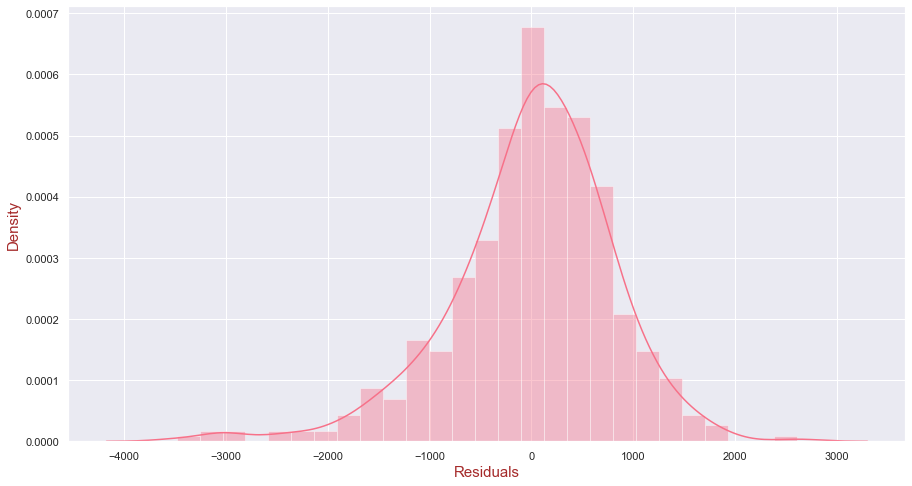

In [3642]:
sns.set_theme(palette=sns.color_palette("husl"))
y_train_pred = lm.predict(X_train_rfe)
res = y_train - y_train_pred
sns.distplot(res)
plt.xlabel('Residuals',fontdict=fontdict)
plt.ylabel('Density',fontdict=fontdict)
plt.show()

So we can see here that error terms are normally distributed with mean around 0

We can also plot Q-Q plot to confirm if error terms are indeed normally distributed

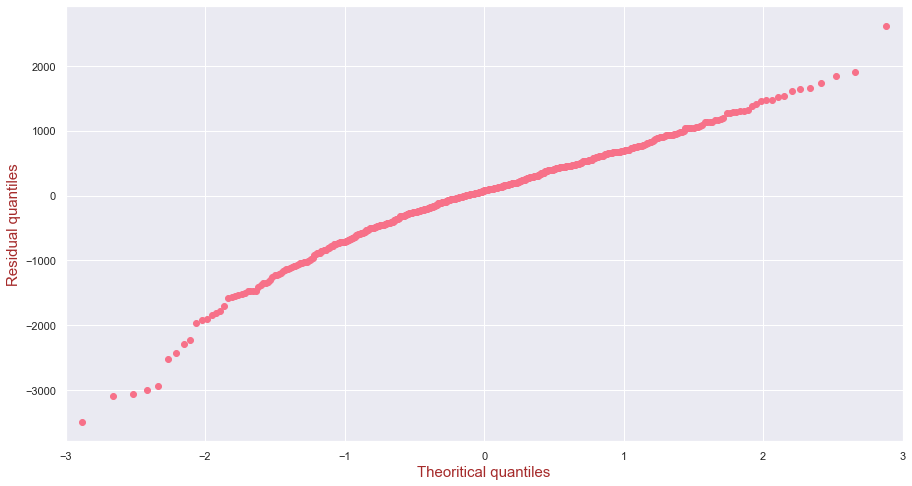

In [3643]:
sm.qqplot(res)
plt.xlabel('Theoritical quantiles',fontdict=fontdict)
plt.ylabel('Residual quantiles',fontdict=fontdict)
plt.show()

Next, we can plot error terms against the predicted y values and check for `Homoscedasticity`

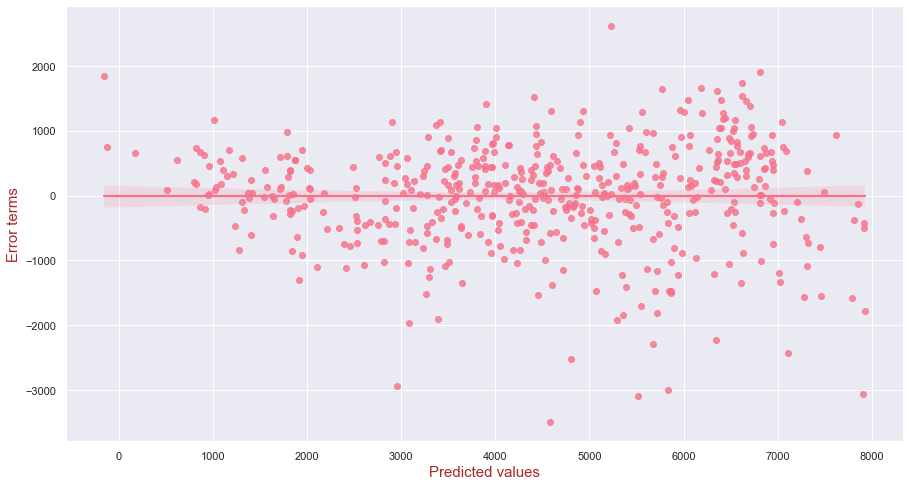

In [3644]:
sns.regplot(x=y_train_pred, y = res)
plt.xlabel('Predicted values',fontdict=fontdict)
plt.ylabel('Error terms',fontdict=fontdict)
plt.show()

Next we will plot error terms against time (date in this case) to confirm there should not be any patterns

In [3645]:
X_train_with_date = X_train.copy(deep=True) # we will add date in upcoming steps

In [3646]:
X_train_with_date.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'day', 'spring', 'summer', 'winter', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Cloudy', 'Light Rain', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September'],
      dtype='object')

In [3647]:
mnth_cols = ['August','December', 'February', 'January', 'July', 'June', 'March', 'May','November', 'October', 'September']

mnth_dict = {'January' : 1, 'February':2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August':8, 'September': 9, 'October': 10, 'November': 11, 'December': 12 }

# we will iterate through the month columns of X_train_with_date
# if any of the column has value 1 for a given row, we will fill the month number (from mnth_dict) in newly created mnth column
def getMonth(x):
    for month in mnth_cols:
        if x[month] == 1:
            return mnth_dict[month]
    return 4

X_train_with_date["mnth"] = X_train_with_date.apply(getMonth,axis=1)

In [3648]:
X_train_with_date["date"] = X_train_with_date.apply(addDate, axis=1)

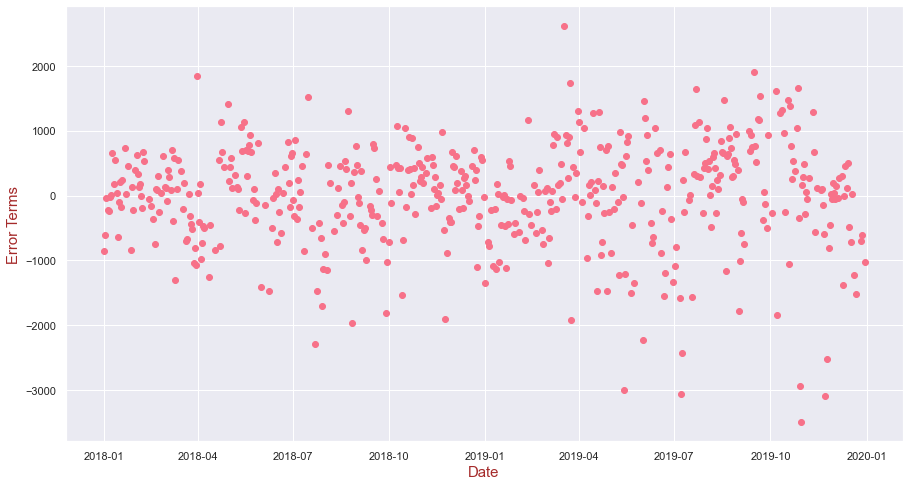

In [3649]:
plt.scatter(X_train_with_date["date"],res)
plt.xlabel('Date',fontdict=fontdict)
plt.ylabel('Error Terms',fontdict=fontdict)
plt.show()

There is no pattern whatsoever among error terms with respect to time

#### Next we will test our model on test data

First, we will scale the numerical columns in test data to the same scale as that of corresponding column in train data

In [3650]:
df_test[numVars] = scaler.transform(df_test[numVars])
df_test[numVars].head()

,temp,atemp,hum,windspeed
184,0.831783,0.769660,0.657364,0.084219
535,0.901354,0.842587,0.610133,0.153728
299,0.511964,0.496145,0.837699,0.334206
221,0.881625,0.795343,0.437098,0.339570
152,0.817246,0.741471,0.314298,0.537414


In [3651]:
df_test[numVars].describe()

,temp,atemp,hum,windspeed
count,220.000000,220.000000,220.000000,220.000000
mean,0.558718,0.532847,0.638221,0.313293
std,0.233187,0.217401,0.148694,0.159584
min,0.046591,0.025950,0.261915,-0.042808
25%,0.355429,0.344870,0.529197,0.198843
50%,0.558172,0.544652,0.625590,0.300126
75%,0.755981,0.713308,0.743798,0.402718
max,0.984424,0.980934,1.002146,0.807474


Next, separate dependent and independent variables

In [3652]:
y_test = df_test.pop('cnt')

In [3653]:
X_train_rfe_wo_const = X_train_rfe.drop(['const'],axis=1) # remove constant

Select columns in test data that were present in the final model, except constant

In [3654]:
X_test = df_test[X_train_rfe_wo_const.columns]

Now we will add constant

In [3655]:
X_test = sm.add_constant(X_test)

Now, we are ready to predict y values from test data

In [3656]:
y_test_pred = lm.predict(X_test)

In [3657]:
r2_score(y_true = y_test, y_pred =  y_test_pred)

0.8045900839678305

`This is a pretty good R2 score and it is quite close the score we got in the training set`

#### So this is a pretty good model with a r2 score of 0.8045 on test data.
#### Model equation:
####  cnt = 1939.15 + 1974.86yr + 417.87workingday + 5168.28temp - 2376.54hum - 1772.5*windspeed + 777.38summer + 1252.57winter + 491.59Saturday - 1726.57Light Rain + 879.72September

Finally let's try to plot the regression plot between y_test and predicted values from test data

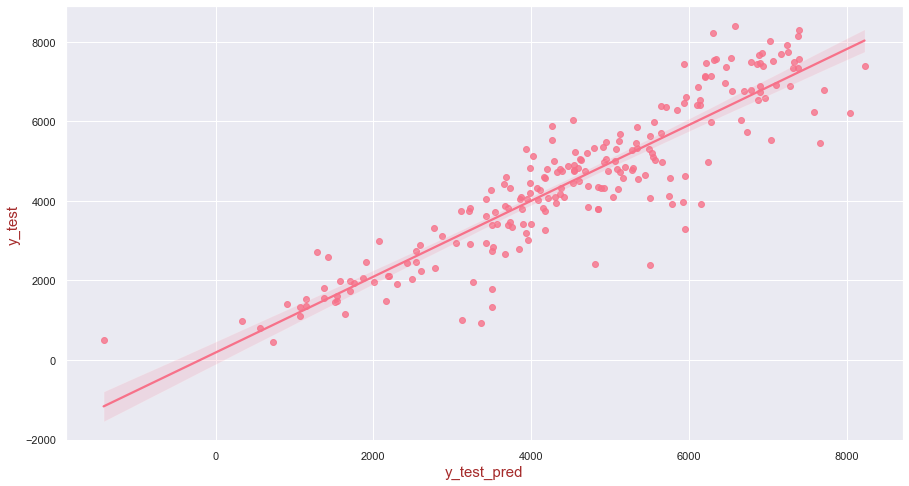

In [3658]:
sns.regplot(y_test_pred,y_test)
plt.xlabel('y_test_pred', fontdict=fontdict)
plt.ylabel('y_test', fontdict=fontdict) 
plt.show()

`We can see that our model gave good and consistent result for both train and test data with a R square value of 0.833 and .8045 for train and test data respectively`

#### Now we will start again from the point where we have both sunday and workingday columns (while creating 1st model  we had two choices -either to drop Sunday or working day, and we dropped Sunday, and this time we will drop 'workingday' and keep Sunday)

In [3659]:
X_train_rfe = X_train_rfe_backup.copy(deep=True)
X_train_rfe.head()

,const,yr,workingday,temp,hum,windspeed,summer,winter,Saturday,Sunday,Light Rain,September
576,1.0,1,1,0.815169,0.725633,0.264686,0,0,0,0,0,0
426,1.0,1,0,0.442393,0.640189,0.255342,0,0,1,0,0,0
728,1.0,1,0,0.245101,0.498067,0.663106,0,0,0,1,0,0
482,1.0,1,0,0.395666,0.504508,0.188475,1,0,1,0,0,0
111,1.0,0,1,0.345824,0.751824,0.380981,1,0,0,0,0,0


In [3660]:
X_train_rfe = X_train_rfe.drop(["workingday"], axis = 1)

In [3661]:
lm = trainModel(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     243.3
Date:                Thu, 20 Oct 2022   Prob (F-statistic):          1.04e-184
Time:                        22:55:09   Log-Likelihood:                -4135.3
No. Observations:                 510   AIC:                             8293.
Df Residuals:                     499   BIC:                             8339.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2314.8794    229.298     10.095      0.0

`Observations after dropping workingday and training the model again`

-  Adjusted R2 score is decently good
-  Saturday has a highly insignificant beta coefficient

In [3662]:
calculateVIF(X_train_rfe)

      Features    VIF
0        const  40.59
3          hum   1.25
6       winter   1.24
2         temp   1.20
5       summer   1.19
4    windspeed   1.16
9   Light Rain   1.11
10   September   1.11
7     Saturday   1.04
8       Sunday   1.04
1           yr   1.03


Nothing to worry about regarding multicollinearity. const has a VIF but it doesn't matter

We are going to drop Saturday

In [3663]:
X_train_rfe = X_train_rfe.drop(["Saturday"], axis = 1)

In [3664]:
lm = trainModel(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     270.2
Date:                Thu, 20 Oct 2022   Prob (F-statistic):          1.05e-185
Time:                        22:55:09   Log-Likelihood:                -4135.9
No. Observations:                 510   AIC:                             8292.
Df Residuals:                     500   BIC:                             8334.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2340.2136    228.010     10.264      0.0

`Observations after dropping Saturday and training the model again`

-  Adjusted R square doesn't get impacted
-  All beta coefficients look good.


In [3665]:
calculateVIF(X_train_rfe)

     Features    VIF
0       const  40.13
3         hum   1.25
6      winter   1.24
2        temp   1.20
5      summer   1.19
4   windspeed   1.16
8  Light Rain   1.11
9   September   1.11
1          yr   1.02
7      Sunday   1.01


Nothing to worry about in multicollinearity. const has a VIF but it doesn't matter

No need to drop further columns.So our 2nd model is ready. Now we will validate and test it.

`Now let's validate the assumptions of linear regression`

-  error terms should be normally distributed
-  Homoscedasticity should be present
-  Error terms should not form any pattern over time
-  predictors and dependent variable should form a linear relationship

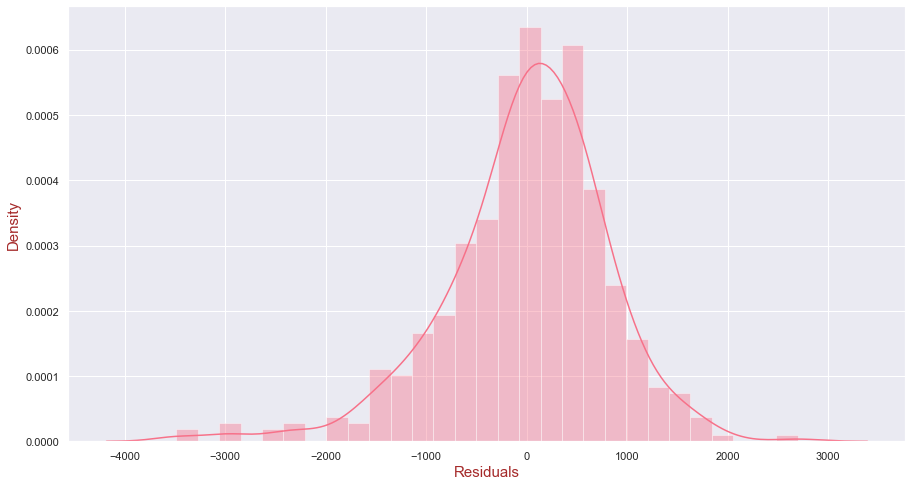

In [3666]:
sns.set_theme(palette=sns.color_palette("husl"))
y_train_pred = lm.predict(X_train_rfe)
res = y_train - y_train_pred
sns.distplot(res)
plt.xlabel('Residuals',fontdict=fontdict)
plt.ylabel('Density',fontdict=fontdict)
plt.show()

So we can see here that error terms are normally distributed with mean around 0

We can also plot Q-Q plot to confirm if error terms are indeed normally distributed

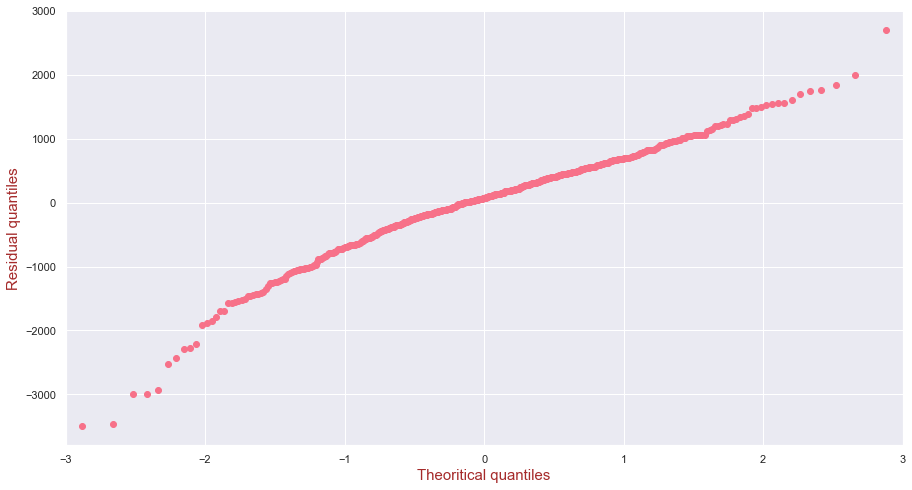

In [3667]:
sm.qqplot(res)
plt.xlabel('Theoritical quantiles',fontdict=fontdict)
plt.ylabel('Residual quantiles',fontdict=fontdict)
plt.show()

We can plot error terms against the predicted y values and check for `Homoscedasticity`

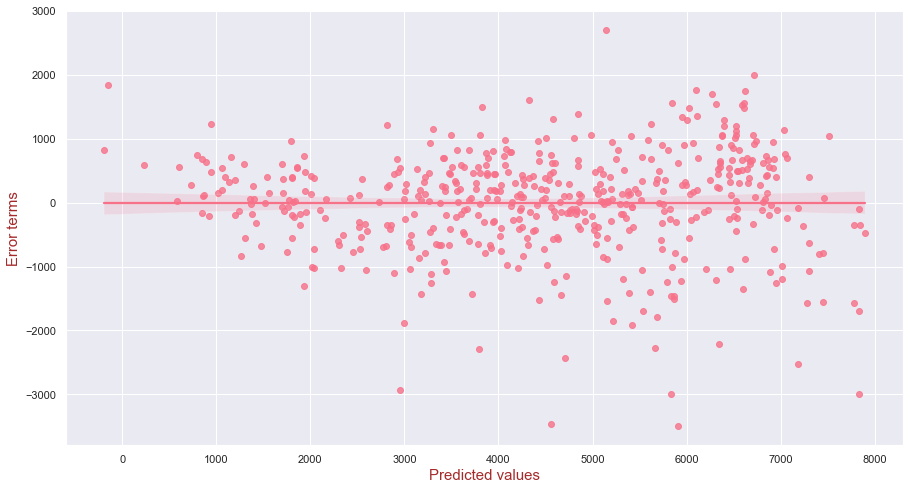

In [3668]:
sns.regplot(x=y_train_pred, y = res)
plt.xlabel('Predicted values',fontdict=fontdict)
plt.ylabel('Error terms',fontdict=fontdict)
plt.show()

Next we will plot error terms against time (date in this case) to confirm there should not be any patterns

In [3669]:
X_train_with_date = X_train.copy(deep=True) # we will add date in upcoming steps

In [3670]:
X_train_with_date["mnth"] = X_train_with_date.apply(getMonth,axis=1)

In [3671]:
X_train_with_date["date"] = X_train_with_date.apply(addDate, axis=1)

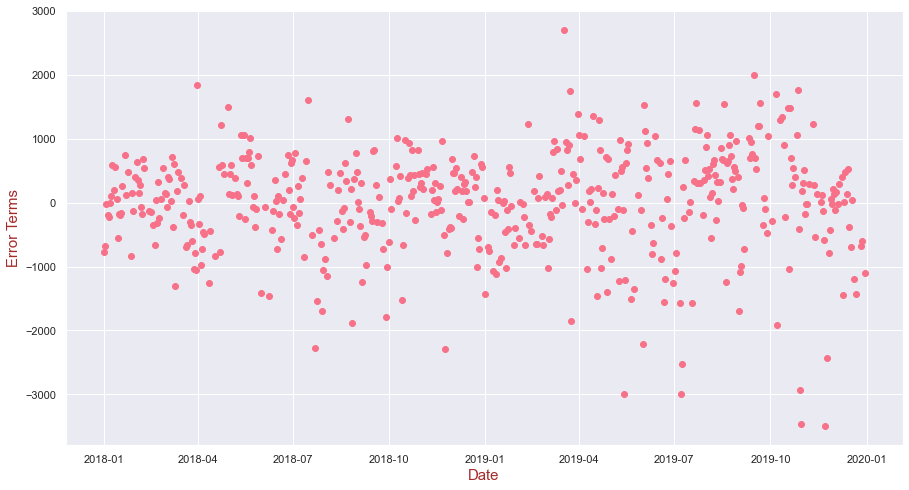

In [3673]:
plt.scatter(X_train_with_date["date"],res)
plt.xlabel('Date',fontdict=fontdict)
plt.ylabel('Error Terms',fontdict=fontdict)
plt.show()

In [3674]:
X_train_rfe_wo_const = X_train_rfe.drop(['const'],axis=1) # remove constant

separate dependent and independent variables

##### Please note that our test model is already scaled because we have already scaled df_test while tesing 1st model

In [3675]:
X_test = df_test[X_train_rfe_wo_const.columns]
X_test = sm.add_constant(X_test) # adding constant

In [3676]:
y_test_pred = lm.predict(X_test)

In [3677]:
r2_score(y_true = y_test, y_pred =  y_test_pred)

0.800823327396912

#### Pretty good r2 score of 0.8008. The 1st model we created has a r2 score of 80.45 on test data, which is just slightly better than this model. So anyways we are going to go with 1st model. 

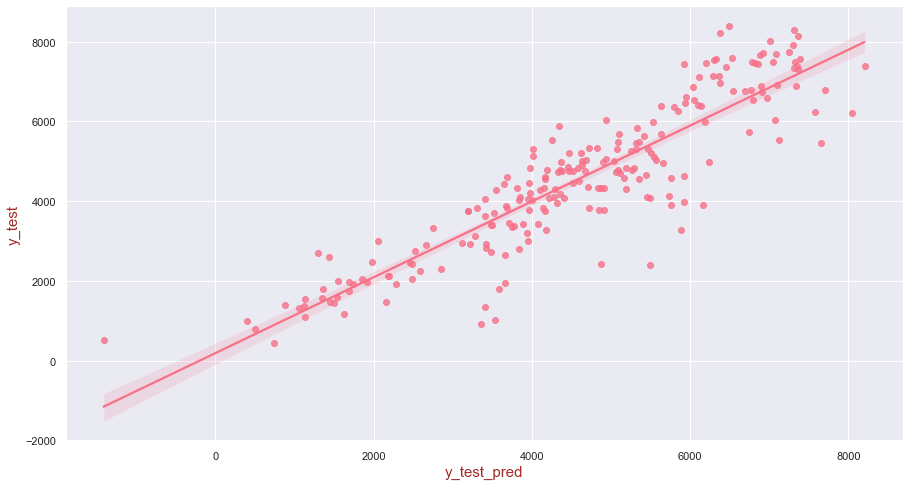

In [3678]:
sns.regplot(y_test_pred,y_test)
plt.xlabel('y_test_pred', fontdict=fontdict)
plt.ylabel('y_test', fontdict=fontdict) 
plt.show()

So our 2nd model has r2 score of 0.8008 and the equation is:

cnt = 2340.21 + 1974.58yr + 5183.23temp - 2378.83hum - 1775.28windspeed + 783.28summer + 1245.69winter - 332.21Sunday - 1700.82Light Rain + 870.93September

#### Final notes

So we have two models with small differences,but model 1 seems slighly better with r2 score of 0.8045 just slightly better than that of 2nd model

